In [ ]:
import torch
import torch.nn as nn
import numpy as np
import math
from kan import KAN

torch.manual_seed(1)
np.random.seed(1)
device = torch.device("cpu")


class PlateWithHole(nn.Module):
    def __init__(self, network_u, network_v, num_epoch, data_type=torch.float32):
        super().__init__()
        self.network_u = network_u
        self.network_v = network_v
        self.num_epoch = num_epoch
        self.data_type = data_type
        self.print_epoch = 100

    def u(self, X):
        x = X[:, 0:1]
        return self.network_u(X) * x

    def v(self, X):
        y = X[:, 1:2]
        return self.network_v(X) * y
    
    def forward(self, X):
        u_val = self.u(X)
        v_val = self.v(X)
        return torch.cat([u_val, v_val], dim=1)


    def strains(self, x, y):
        x.requires_grad_(True)
        y.requires_grad_(True)

        X = torch.cat([x, y], dim=1)
        U = self.u(X)
        V = self.v(X)

        du_dx = torch.autograd.grad(U, x, torch.ones_like(U), create_graph=True)[0]
        du_dy = torch.autograd.grad(U, y, torch.ones_like(U), create_graph=True)[0]
        dv_dx = torch.autograd.grad(V, x, torch.ones_like(V), create_graph=True)[0]
        dv_dy = torch.autograd.grad(V, y, torch.ones_like(V), create_graph=True)[0]

        epsilon_xx = du_dx
        epsilon_yy = dv_dy
        epsilon_xy = du_dy + dv_dx

        return epsilon_xx, epsilon_yy, epsilon_xy

    def stresses(self, x, y):
        E = 5.0
        nu = 0.3

        epsilon_xx, epsilon_yy, epsilon_xy = self.strains(x, y)

        sigma_xx = E / (1 - nu**2) * (epsilon_xx + nu * epsilon_yy)
        sigma_yy = E / (1 - nu**2) * (epsilon_yy + nu * epsilon_xx)
        sigma_xy = E / (2 * (1 + nu)) * epsilon_xy

        return sigma_xx, sigma_yy, sigma_xy

    def equilibrium(self, x, y):
        sigma_xx, sigma_yy, sigma_xy = self.stresses(x, y)

        dsigma_xx_dx = torch.autograd.grad(sigma_xx, x, torch.ones_like(sigma_xx), create_graph=True)[0]
        dsigma_xy_dy = torch.autograd.grad(sigma_xy, y, torch.ones_like(sigma_xy), create_graph=True)[0]
        dsigma_yy_dy = torch.autograd.grad(sigma_yy, y, torch.ones_like(sigma_yy), create_graph=True)[0]
        dsigma_xy_dx = torch.autograd.grad(sigma_xy, x, torch.ones_like(sigma_xy), create_graph=True)[0]

        return dsigma_xx_dx, dsigma_yy_dy, dsigma_xy_dy, dsigma_xy_dx

    def loss_all(self, X_dom):
        x = X_dom[:, 0:1]
        y = X_dom[:, 1:2]

        dsigma_xx_dx, dsigma_yy_dy, dsigma_xy_dy, dsigma_xy_dx = self.equilibrium(x, y)
        ge_x = dsigma_xx_dx + dsigma_xy_dy
        ge_y = dsigma_yy_dy + dsigma_xy_dx

        loss_eq = torch.mean(ge_x**2) + torch.mean(ge_y**2)

        # Geometry
        Lx = 1.0
        Ly = 1.0
        r = 0.2

        ns_a = 51
        ns_u = 101
        ns_b = 101
        ns_l = 101
        ns_r = 101

        # Top boundary
        x_u = torch.linspace(0, Lx, ns_u).view(-1, 1)
        y_u = torch.ones_like(x_u)
        sigma_xx_u, sigma_yy_u, sigma_xy_u = self.stresses(x_u, y_u)
        loss_D1 = torch.mean(sigma_yy_u**2) + torch.mean(sigma_xy_u**2)

        # Bottom boundary
        x_b = torch.linspace(r, Lx, ns_b).view(-1, 1)
        y_b = torch.zeros_like(x_b)
        sigma_xx_b, sigma_yy_b, sigma_xy_b = self.stresses(x_b, y_b)
        loss_D2 = torch.mean(sigma_xy_b**2)

        # Left boundary
        x_l = torch.zeros(ns_l, 1)
        y_l = torch.linspace(0, Ly, ns_l).view(-1, 1)
        sigma_xx_l, sigma_yy_l, sigma_xy_l = self.stresses(x_l, y_l)
        loss_D3 = torch.mean(sigma_xy_l**2)

        # Right boundary
        x_r = torch.ones(ns_r, 1) * Lx
        y_r = torch.linspace(0, Ly, ns_r).view(-1, 1)
        sigma_xx_r, sigma_yy_r, sigma_xy_r = self.stresses(x_r, y_r)
        loss_D4 = torch.mean(sigma_xy_r**2) + torch.mean((sigma_xx_r - 1.0)**2)

        # Arc boundary
        theta = torch.linspace(0, math.pi / 2, ns_a).view(-1, 1)
        x_a = r * torch.cos(theta)
        y_a = r * torch.sin(theta)

        nx = -torch.cos(theta)
        ny = -torch.sin(theta)

        sigma_xx_a, sigma_yy_a, sigma_xy_a = self.stresses(x_a, y_a)
        tnx = sigma_xx_a * nx + sigma_xy_a * ny
        tny = sigma_xy_a * nx + sigma_yy_a * ny
        loss_D5 = torch.mean(tnx**2) + torch.mean(tny**2)

        loss_bc = loss_D1 + loss_D2 + loss_D3 + loss_D4 + loss_D5

        return loss_eq, loss_bc

    def train_model(self, X_dom, optimizer):
        for epoch in range(self.num_epoch):
            optimizer.zero_grad()
            loss_eq, loss_bc = self.loss_all(X_dom)
            loss = loss_eq + loss_bc
            loss.backward()
            optimizer.step()

            if (epoch + 1) % self.print_epoch == 0:
                print(
                    f"Epoch {epoch+1:4d} | "
                    f"Loss {loss.item():.6f} | "
                    f"Eq {loss_eq.item():.6f} | "
                    f"BC {loss_bc.item():.6f}"
                )


In [13]:
Lx = 1.0
Ly = 1.0
r = 0.2
num_points = 100

x = torch.linspace(0, Lx, num_points)
y = torch.linspace(0, Ly, num_points)
Xg, Yg = torch.meshgrid(x, y, indexing='ij')

points = torch.stack([Xg.flatten(), Yg.flatten()], dim=1)
dist = torch.sqrt(points[:, 0]**2 + points[:, 1]**2)
X_dom = points[dist > r]


In [17]:
u_net = KAN(width=[2, 8, 4, 1], grid=15, k=3)
v_net = KAN(width=[2, 8, 4, 1], grid=15, k=3)

model = PlateWithHole(u_net, v_net, num_epoch=200)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

model.train()

model.train_model(X_dom, optimizer)


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Epoch  100 | Loss 0.070681 | Eq 0.024396 | BC 0.046285
Epoch  200 | Loss 0.036230 | Eq 0.007822 | BC 0.028409


In [20]:
# L-BFGS optimizer

lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=800,
    history_size=100,
    tolerance_grad=1e-9,
    tolerance_change=1e-9,
    line_search_fn="strong_wolfe"
)

lbfgs_iter = 0

def closure():
    global lbfgs_iter
    lbfgs.zero_grad()

    loss_eq, loss_bc = model.loss_all(X_dom)
    loss = loss_eq + loss_bc

    loss.backward()

    if lbfgs_iter % 25 == 0:
        print(
            f"L-BFGS iter {lbfgs_iter:4d} | "
            f"Loss {loss.item():.6f} | "
            f"Eq {loss_eq.item():.6f} | "
            f"BC {loss_bc.item():.6f}"
        )

    lbfgs_iter += 1
    return loss

print("Starting L-BFGS...")
lbfgs.step(closure)
print("L-BFGS finished.")


Starting L-BFGS...
L-BFGS iter    0 | Loss 0.036143 | Eq 0.008159 | BC 0.027984
L-BFGS iter   25 | Loss 0.034785 | Eq 0.007458 | BC 0.027328
L-BFGS iter   50 | Loss 0.032496 | Eq 0.007791 | BC 0.024705
L-BFGS iter   75 | Loss 0.030445 | Eq 0.007965 | BC 0.022480
L-BFGS iter  100 | Loss 0.028254 | Eq 0.007509 | BC 0.020745
L-BFGS iter  125 | Loss 0.026794 | Eq 0.006824 | BC 0.019970
L-BFGS iter  150 | Loss 0.025732 | Eq 0.006424 | BC 0.019308
L-BFGS iter  175 | Loss 0.024776 | Eq 0.006188 | BC 0.018588
L-BFGS iter  200 | Loss 0.023999 | Eq 0.005903 | BC 0.018096
L-BFGS iter  225 | Loss 0.023322 | Eq 0.005771 | BC 0.017551
L-BFGS iter  250 | Loss 0.022705 | Eq 0.005739 | BC 0.016965
L-BFGS iter  275 | Loss 0.022150 | Eq 0.005624 | BC 0.016526
L-BFGS iter  300 | Loss 0.021650 | Eq 0.005527 | BC 0.016123
L-BFGS iter  325 | Loss 0.021034 | Eq 0.005453 | BC 0.015581
L-BFGS iter  350 | Loss 0.020436 | Eq 0.005196 | BC 0.015240
L-BFGS iter  375 | Loss 0.019936 | Eq 0.005204 | BC 0.014732
L-BFG

In [23]:
# L-BFGS optimizer

lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=700,
    history_size=100,
    tolerance_grad=1e-9,
    tolerance_change=1e-9,
    line_search_fn="strong_wolfe"
)

lbfgs_iter = 0

def closure():
    global lbfgs_iter
    lbfgs.zero_grad()

    loss_eq, loss_bc = model.loss_all(X_dom)
    loss = loss_eq + loss_bc

    loss.backward()

    if lbfgs_iter % 25 == 0:
        print(
            f"L-BFGS iter {lbfgs_iter:4d} | "
            f"Loss {loss.item():.6f} | "
            f"Eq {loss_eq.item():.6f} | "
            f"BC {loss_bc.item():.6f}"
        )

    lbfgs_iter += 1
    return loss

print("Starting L-BFGS...")
lbfgs.step(closure)
print("L-BFGS finished.")


Starting L-BFGS...
L-BFGS iter    0 | Loss 0.009594 | Eq 0.004235 | BC 0.005360
L-BFGS iter   25 | Loss 0.009486 | Eq 0.004178 | BC 0.005307
L-BFGS iter   50 | Loss 0.009281 | Eq 0.004024 | BC 0.005257
L-BFGS iter   75 | Loss 0.009025 | Eq 0.003942 | BC 0.005083
L-BFGS iter  100 | Loss 0.008651 | Eq 0.003929 | BC 0.004723
L-BFGS iter  125 | Loss 0.008396 | Eq 0.003813 | BC 0.004582
L-BFGS iter  150 | Loss 0.008153 | Eq 0.003725 | BC 0.004428
L-BFGS iter  175 | Loss 0.007850 | Eq 0.003721 | BC 0.004129
L-BFGS iter  200 | Loss 0.007502 | Eq 0.003747 | BC 0.003755
L-BFGS iter  225 | Loss 0.007194 | Eq 0.003679 | BC 0.003515
L-BFGS iter  250 | Loss 0.006956 | Eq 0.003667 | BC 0.003289
L-BFGS iter  275 | Loss 0.006711 | Eq 0.003707 | BC 0.003004
L-BFGS iter  300 | Loss 0.006452 | Eq 0.003694 | BC 0.002758
L-BFGS iter  325 | Loss 0.006189 | Eq 0.003570 | BC 0.002619
L-BFGS iter  350 | Loss 0.006028 | Eq 0.003526 | BC 0.002501
L-BFGS iter  375 | Loss 0.005853 | Eq 0.003491 | BC 0.002362
L-BFG

In [26]:
# L-BFGS optimizer

lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=550,
    history_size=50,
    tolerance_grad=1e-9,
    tolerance_change=1e-9,
    line_search_fn="strong_wolfe"
)

lbfgs_iter = 0

def closure():
    global lbfgs_iter
    lbfgs.zero_grad()

    loss_eq, loss_bc = model.loss_all(X_dom)
    loss = loss_eq + loss_bc

    loss.backward()

    if lbfgs_iter % 25 == 0:
        print(
            f"L-BFGS iter {lbfgs_iter:4d} | "
            f"Loss {loss.item():.6f} | "
            f"Eq {loss_eq.item():.6f} | "
            f"BC {loss_bc.item():.6f}"
        )

    lbfgs_iter += 1
    return loss

print("Starting L-BFGS...")
lbfgs.step(closure)
print("L-BFGS finished.")


Starting L-BFGS...
L-BFGS iter    0 | Loss 0.004409 | Eq 0.002767 | BC 0.001642
L-BFGS iter   25 | Loss 0.004386 | Eq 0.002756 | BC 0.001630
L-BFGS iter   50 | Loss 0.004353 | Eq 0.002738 | BC 0.001615
L-BFGS iter   75 | Loss 0.004327 | Eq 0.002734 | BC 0.001593
L-BFGS iter  100 | Loss 0.004299 | Eq 0.002734 | BC 0.001565
L-BFGS iter  125 | Loss 0.004271 | Eq 0.002700 | BC 0.001571
L-BFGS iter  150 | Loss 0.004241 | Eq 0.002685 | BC 0.001556
L-BFGS iter  175 | Loss 0.004213 | Eq 0.002657 | BC 0.001556
L-BFGS iter  200 | Loss 0.004188 | Eq 0.002638 | BC 0.001550
L-BFGS iter  225 | Loss 0.004163 | Eq 0.002623 | BC 0.001541
L-BFGS iter  250 | Loss 0.004135 | Eq 0.002605 | BC 0.001530
L-BFGS iter  275 | Loss 0.004103 | Eq 0.002601 | BC 0.001502
L-BFGS iter  300 | Loss 0.004070 | Eq 0.002596 | BC 0.001474
L-BFGS iter  325 | Loss 0.004038 | Eq 0.002600 | BC 0.001438
L-BFGS iter  350 | Loss 0.004008 | Eq 0.002610 | BC 0.001398
L-BFGS iter  375 | Loss 0.003976 | Eq 0.002585 | BC 0.001391
L-BFG

In [29]:
# L-BFGS optimizer

lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=1200,
    history_size=100,
    tolerance_grad=1e-9,
    tolerance_change=1e-9,
    line_search_fn="strong_wolfe"
)

lbfgs_iter = 0

def closure():
    global lbfgs_iter
    lbfgs.zero_grad()

    loss_eq, loss_bc = model.loss_all(X_dom)
    loss = loss_eq + loss_bc

    loss.backward()

    if lbfgs_iter % 25 == 0:
        print(
            f"L-BFGS iter {lbfgs_iter:4d} | "
            f"Loss {loss.item():.6f} | "
            f"Eq {loss_eq.item():.6f} | "
            f"BC {loss_bc.item():.6f}"
        )

    lbfgs_iter += 1
    return loss

print("Starting L-BFGS...")
lbfgs.step(closure)
print("L-BFGS finished.")


Starting L-BFGS...
L-BFGS iter    0 | Loss 0.003677 | Eq 0.002453 | BC 0.001224
L-BFGS iter   25 | Loss 0.003662 | Eq 0.002466 | BC 0.001197
L-BFGS iter   50 | Loss 0.003634 | Eq 0.002435 | BC 0.001199
L-BFGS iter   75 | Loss 0.003603 | Eq 0.002404 | BC 0.001198
L-BFGS iter  100 | Loss 0.003558 | Eq 0.002378 | BC 0.001179
L-BFGS iter  125 | Loss 0.003533 | Eq 0.002370 | BC 0.001163
L-BFGS iter  150 | Loss 0.003515 | Eq 0.002375 | BC 0.001140
L-BFGS iter  175 | Loss 0.003491 | Eq 0.002379 | BC 0.001113
L-BFGS iter  200 | Loss 0.003459 | Eq 0.002354 | BC 0.001105
L-BFGS iter  225 | Loss 0.003425 | Eq 0.002337 | BC 0.001088
L-BFGS iter  250 | Loss 0.003400 | Eq 0.002323 | BC 0.001078
L-BFGS iter  275 | Loss 0.003369 | Eq 0.002311 | BC 0.001058
L-BFGS iter  300 | Loss 0.003327 | Eq 0.002310 | BC 0.001016
L-BFGS iter  325 | Loss 0.003286 | Eq 0.002316 | BC 0.000970
L-BFGS iter  350 | Loss 0.003256 | Eq 0.002322 | BC 0.000934
L-BFGS iter  375 | Loss 0.003224 | Eq 0.002309 | BC 0.000916
L-BFG

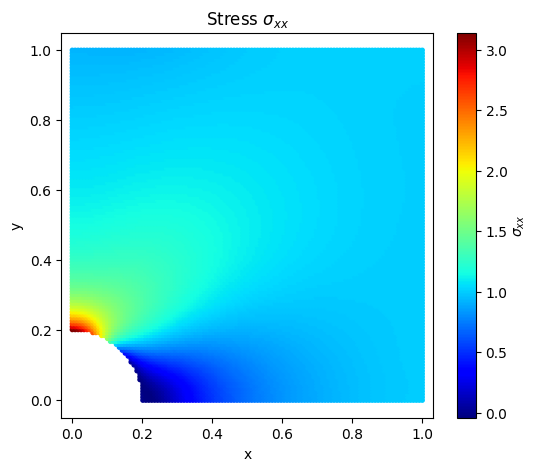

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt

Lx = 1.0
Ly = 1.0
r = 0.2

num_points = 120

x = np.linspace(0, Lx, num_points, dtype=np.float32)
y = np.linspace(0, Ly, num_points, dtype=np.float32)

Xg, Yg = np.meshgrid(x, y)
points = np.stack((Xg.flatten(), Yg.flatten()), axis=1)

distances = np.sqrt(points[:,0]**2 + points[:,1]**2)
valid_points = points[distances > r]
pts = torch.tensor(valid_points, dtype=torch.float32, device=device)

X = pts[:, 0:1].clone().detach().requires_grad_(True)
Y = pts[:, 1:2].clone().detach().requires_grad_(True)
sigma_xx, sigma_yy, sigma_xy = model.stresses(X, Y)

sxx = sigma_xx.detach().cpu().numpy()
with torch.no_grad():
    disp = model(pts)

u_disp = disp[:,0].cpu().numpy()
v_disp = disp[:,1].cpu().numpy()

plt.figure(figsize=(6,5))
plt.scatter(valid_points[:,0], valid_points[:,1],
            c=sxx, cmap='jet', s=8)
plt.colorbar(label=r'$\sigma_{xx}$')
plt.axis('equal')
plt.title(r'Stress $\sigma_{xx}$')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


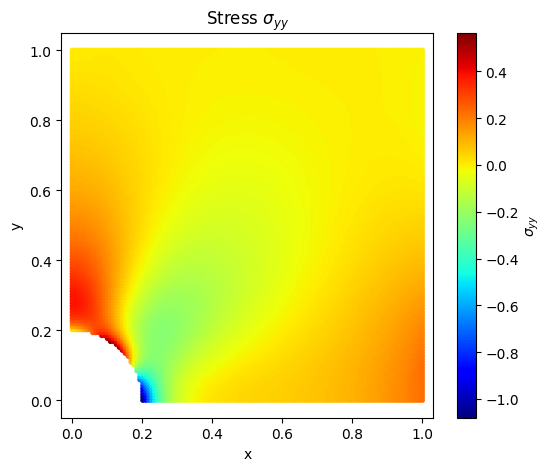

In [33]:
syy = sigma_yy.detach().cpu().numpy()

plt.figure(figsize=(6,5))
plt.scatter(
    valid_points[:,0],
    valid_points[:,1],
    c=syy,
    cmap='jet',
    s=8
)
plt.colorbar(label=r'$\sigma_{yy}$')
plt.axis('equal')
plt.title(r'Stress $\sigma_{yy}$')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


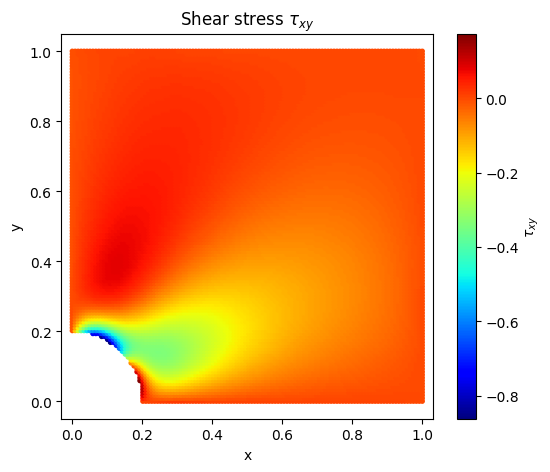

In [34]:
sxy = sigma_xy.detach().cpu().numpy()

plt.figure(figsize=(6,5))
plt.scatter(
    valid_points[:,0],
    valid_points[:,1],
    c=sxy,
    cmap='jet',
    s=8
)
plt.colorbar(label=r'$\tau_{xy}$')
plt.axis('equal')
plt.title(r'Shear stress $\tau_{xy}$')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


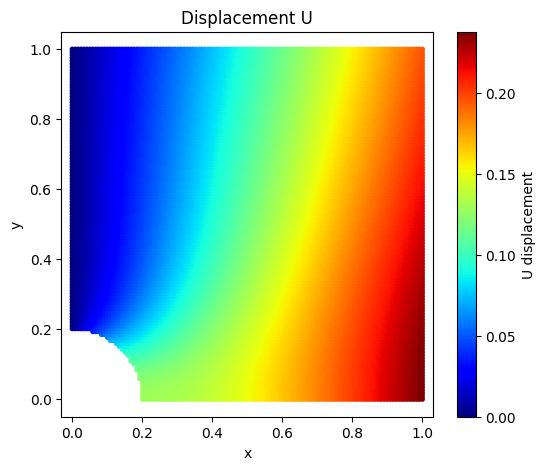

In [31]:
plt.figure(figsize=(6,5))
plt.scatter(valid_points[:,0], valid_points[:,1],
            c=u_disp, cmap='jet', s=8)
plt.colorbar(label='U displacement')
plt.axis('equal')
plt.title('Displacement U')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


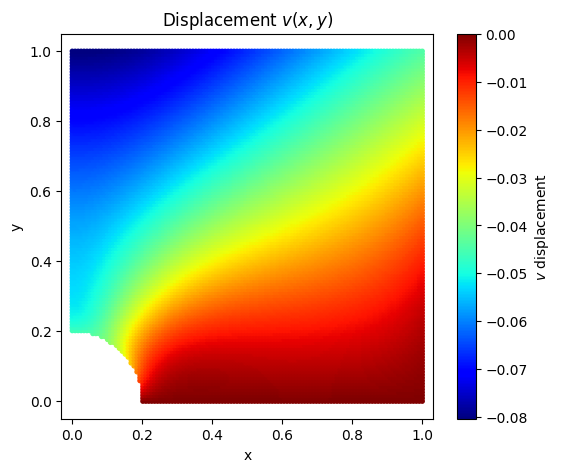

In [35]:
plt.figure(figsize=(6,5))
plt.scatter(
    valid_points[:,0],
    valid_points[:,1],
    c=v_disp,
    cmap='jet',
    s=8
)
plt.colorbar(label=r'$v$ displacement')
plt.axis('equal')
plt.title(r'Displacement $v(x,y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
